<a href="https://colab.research.google.com/github/AnalyticalHarry/Econometrics/blob/main/INVESTMENT_ON_FAANG_COMPANIES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INVESTMENT ON FAANG COMPANIES**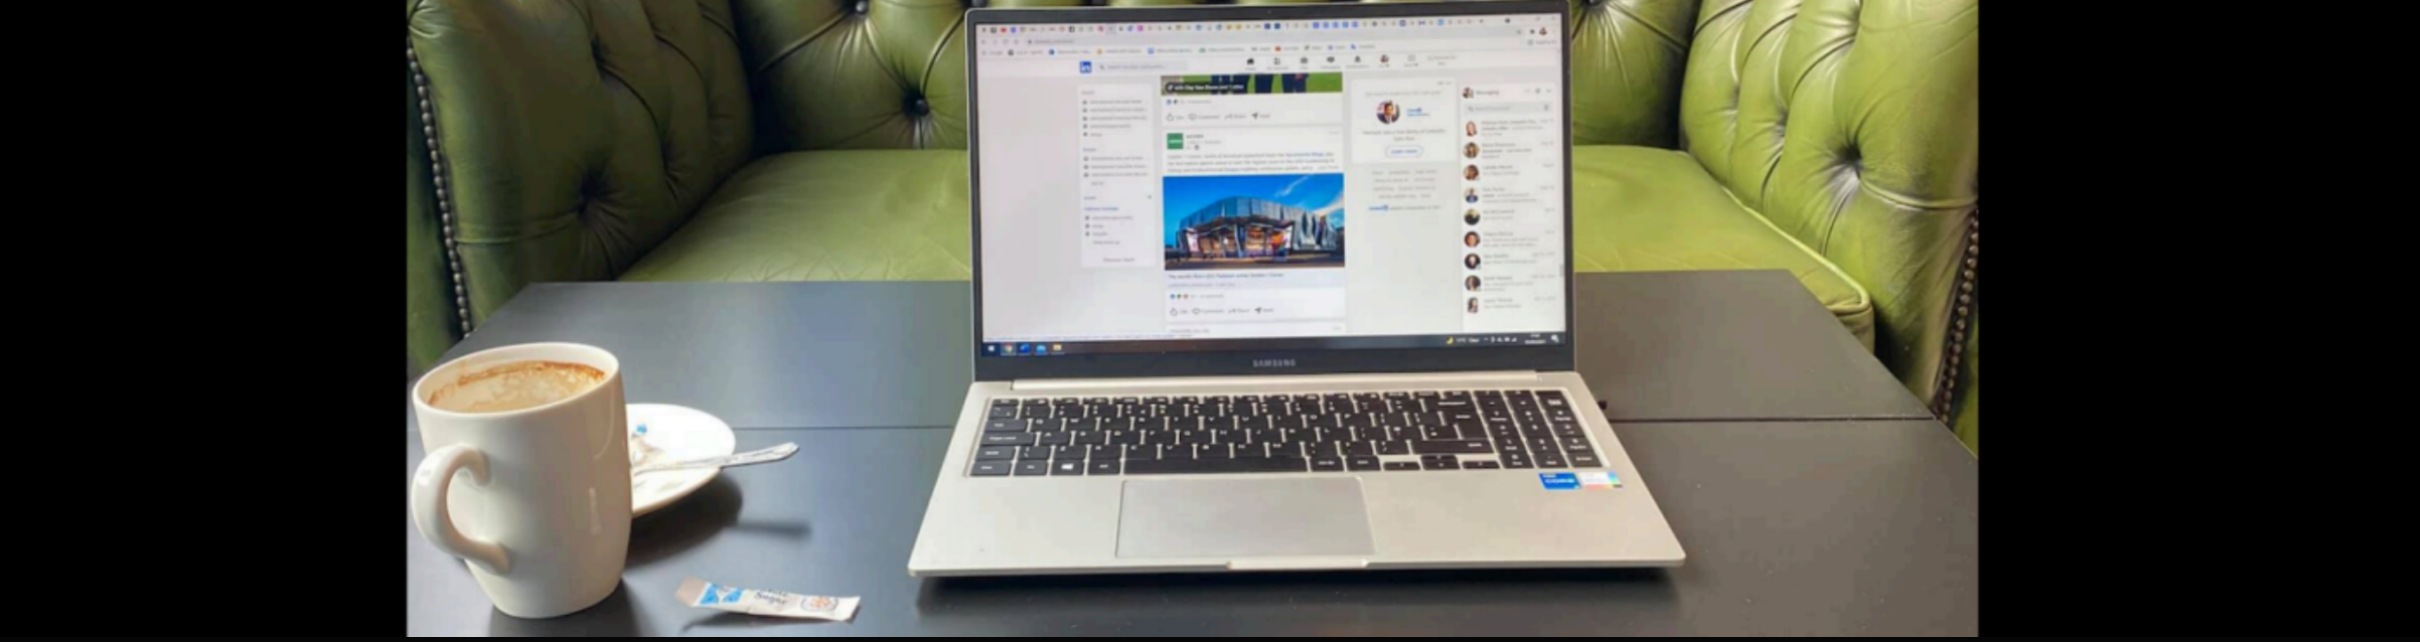

# **HEMANT THAPA**

In [ ]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.ticker import StrMethodFormatter
from datetime import datetime

In [ ]:
class StockDataFetcher:
    def __init__(self, symbol, start_date, end_date, token):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.token = token
        self._data = None
        self._error = None

    @property
    def data(self):
        if self._data is None and self._error is None:
            try:
                url = f'https://api.tiingo.com/tiingo/daily/{self.symbol}/prices'
                params = {
                    'token': self.token,
                    'startDate': self.start_date,
                    'endDate': self.end_date
                }
                response = requests.get(url, params=params)
                if response.status_code == 200:
                    self._data = response.json()
                else:
                    self._error = f"Error: {response.status_code}"
            except Exception as e:
                self._error = str(e)
        return self._data

    @property
    def error(self):
        if self._error is None:
            self.data
        return self._error

    def process_data(self):
        df = pd.DataFrame(self.data)
        if not df.empty:
            df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%M:%S.%fZ')
            df.set_index('date', inplace=True)
        return df

def stock_data(symbols, api, start_date, end_date):
    data = {}
    for symbol in symbols:
        data[symbol] = StockDataFetcher(symbol, start_date, end_date, api).process_data()
    return data

In [ ]:
faang_symbols = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOGL']
faang_data = stock_data(faang_symbols, '3e763e4c131d68c2c53c9b6ca05a5784d947f5b3', '2022-01-01', datetime.today().strftime('%Y-%m-%d'))

meta = faang_data['META']
amzn = faang_data['AMZN']
aapl = faang_data['AAPL']
nflx = faang_data['NFLX']
googl = faang_data['GOOGL']

In [ ]:
meta.shape, amzn.shape, aapl.shape, nflx.shape, googl.shape

In [ ]:
class line_plot:
    def __init__(self, faang_data):
        self.faang_data = faang_data

    def plot_series(self, symbols):
        num_plots = len(symbols)
        num_rows = (num_plots + 2) // 3
        num_cols = min(num_plots, 3)

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

        for i, symbol in enumerate(symbols):
            row = i // num_cols
            col = i % num_cols

            adjclose = self.faang_data[symbol]['adjClose']
            if num_rows == 1:
                ax = axes[col]
            else:
                ax = axes[row, col]

            ax.plot(adjclose.index, adjclose.values, label=symbol, lw=1)
            ax.set_title(f'Adjusted Close {symbol}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Adjusted Close Price')
            ax.legend()
            ax.grid(True, ls='--', alpha=0.5)
            ax.tick_params(axis='x', rotation=30)

        for i in range(len(symbols), num_rows * num_cols):
            if num_rows == 1:
                fig.delaxes(axes[i])
            else:
                fig.delaxes(axes[i // num_cols, i % num_cols])

        plt.tight_layout()
        plt.show()

In [ ]:
time_Series = line_plot(faang_data)
stocks = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOGL']
time_Series.plot_series(stocks)

In [ ]:
def fundamental_analysis(faang_symbols):
    fundamental_data = {}
    for symbol in faang_symbols:
        stock = yf.Ticker(symbol)
        info = stock.info
        market_cap = info.get('marketCap', float('nan'))
        pe_ratio = info.get('trailingPE', float('nan'))
        pb_ratio = info.get('priceToBook', float('nan'))
        dividend_yield = info.get('dividendYield', float('nan'))

        fundamental_data[symbol] = pd.DataFrame({
            'Market Cap': [market_cap],
            'P/E Ratio': [pe_ratio],
            'P/B Ratio': [pb_ratio],
            'Dividend Yield': [dividend_yield]
        })
    return fundamental_data

In [ ]:
faang_fundamentals = fundamental_analysis(faang_symbols)

for i, j in faang_fundamentals.items():
    print(f"\nFundamental Analysis for {i}:")
    print(j)


In [ ]:
spy = StockDataFetcher('SPY', '2022-01-01', datetime.today().strftime('%Y-%m-%d'), '3e763e4c131d68c2c53c9b6ca05a5784d947f5b3').process_data()

In [ ]:
spy[:5]

In [ ]:
spy.shape

In [ ]:
spy.dtypes

In [ ]:
def spy_vs_faang_all(spy_data, faang_data):
    spy_close = spy_data['adjClose']
    faang_symbols = list(faang_data.keys())
    num_rows = (len(faang_symbols) + 2) // 3
    for i in range(0, len(faang_symbols), 3):
        fig, axes = plt.subplots(1, min(3, len(faang_symbols)-i), figsize=(15, 5))
        for j, symbol in enumerate(faang_symbols[i:i+3]):
            faang_close = faang_data[symbol]['adjClose']
            axes[j].scatter(spy_close, faang_close, color='black', alpha=0.5)
            axes[j].set_xlabel('SPY Close Price')
            axes[j].set_ylabel(f'{symbol} Close Price')
            axes[j].set_title(f'Scatter Plot: SPY vs {symbol}')
            axes[j].grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
spy_vs_faang_all(spy, faang_data)

In [ ]:
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
class Correlation:
    def __init__(self, spy_data, faang_data):
        self.spy_data = spy_data
        self.faang_data = faang_data

    def plot(self, degree=2):
        spy_close = self.spy_data['adjClose'].values.reshape(-1, 1)
        faang_symbols = list(self.faang_data.keys())
        num_rows = (len(faang_symbols) + 2) // 3
        for i in range(0, len(faang_symbols), 3):
            fig, axes = plt.subplots(1, min(3, len(faang_symbols)-i), figsize=(15, 5))
            for j, symbol in enumerate(faang_symbols[i:i+3]):
                faang_close = self.faang_data[symbol]['adjClose'].values.reshape(-1, 1)
                poly_features = PolynomialFeatures(degree=degree)
                spy_poly = poly_features.fit_transform(spy_close)
                model = LinearRegression()
                model.fit(spy_poly, faang_close)
                faang_close_pred = model.predict(spy_poly)

                sorted_indices = np.argsort(spy_close[:, 0])
                spy_close_sorted = spy_close[sorted_indices]
                faang_close_pred_sorted = faang_close_pred[sorted_indices]

                axes[j].scatter(spy_close, faang_close, color='black', alpha=0.5, label='Actual')
                axes[j].plot(spy_close_sorted, faang_close_pred_sorted, color='red', label='Predicted')
                axes[j].set_xlabel('SPY Close Price')
                axes[j].set_ylabel(f'{symbol} Close Price')
                axes[j].set_title(f'SPY vs {symbol}')
                axes[j].legend()
                axes[j].grid(True, ls='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

    def residual_analysis(self, degree=2):
        spy_close = self.spy_data['adjClose'].values.reshape(-1, 1)
        faang_symbols = list(self.faang_data.keys())

        residual_data = []
        for symbol in faang_symbols:
            faang_close = self.faang_data[symbol]['adjClose'].values.reshape(-1, 1)

            # Feature Scaling
            scaler = StandardScaler()
            spy_scaled = scaler.fit_transform(spy_close)
            poly_features = PolynomialFeatures(degree=degree)
            spy_poly = poly_features.fit_transform(spy_scaled)

            # Polynomial Regression
            model = LinearRegression()
            model.fit(spy_poly, faang_close)
            faang_close_pred = model.predict(spy_poly)

            # Residuals
            residuals = faang_close - faang_close_pred

            # Residual Plot
            residual_data.append((symbol, residuals))

            # QQ Plot
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            ax1.scatter(faang_close_pred, residuals, color='black', alpha=0.5)
            ax1.axhline(y=0, color='red', linestyle='--')
            ax1.set_xlabel('Predicted Values')
            ax1.set_ylabel('Residuals')
            ax1.set_title(f'Residual Plot: {symbol}')
            ax1.grid(True, ls='--', alpha=0.5)

            stats.probplot(residuals.flatten(), plot=ax2)
            ax2.get_lines()[1].set_linestyle('--')
            ax2.set_title(f'QQ Plot: Residuals for {symbol}')

            plt.tight_layout()
            plt.show()

        # Model evaluation
        eval_data = []
        for symbol, residuals in residual_data:
            faang_close = self.faang_data[symbol]['adjClose'].values.reshape(-1, 1)
            faang_close_pred = faang_close - residuals

            r_squared = r2_score(faang_close, faang_close_pred)
            mse = mean_squared_error(faang_close, faang_close_pred)
            mae = mean_absolute_error(faang_close, faang_close_pred)
            rmse = np.sqrt(mse)
            eval_data.append((symbol, r_squared, mse, mae, rmse))
        eval = pd.DataFrame(eval_data, columns=['Symbol', 'R-squared', 'MSE', 'MAE', 'RMSE'])
        print("Model Evaluation:")
        return eval

In [ ]:
correl = Correlation(spy, faang_data)
correl.plot(degree=4)

In [ ]:
correl.residual_analysis(degree=4)

In [ ]:
# 10 year return on your portfolio
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
start='2014-05-11'
end=datetime.today().strftime('%Y-%m-%d')
data = yf.download(tickers, start=start, end=end)['Adj Close']
initial_investment = 100000 / len(tickers)
shares = initial_investment / data.iloc[0]
portfolio_value = (shares * data).sum(axis=1)

In [ ]:
# individual contributions to the portfolio value over time
contributions = pd.DataFrame()
for ticker in tickers:
    contributions[ticker] = shares[ticker] * data[ticker]
# total portfolio value over time
portfolio_value = contributions.sum(axis=1)

plt.figure(figsize=(20, 6))
for ticker in tickers:
    plt.plot(contributions.index, contributions[ticker], label=ticker, lw=1)
plt.title('Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(portfolio_value.resample('M').last().index, portfolio_value.resample('M').last(), color='black', marker='o', linestyle='--')
plt.title('Total - Monthly Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.xticks(portfolio_value.resample('M').last().index[::6], rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.grid(True, ls='--', alpha=0.5)
plt.show()


In [ ]:
class CumulativeReturns:
    def __init__(self, tickers, start_date, end_date):
        self._tickers = tickers
        self._start_date = start_date
        self._end_date = end_date
        self._faang_data = self._fetch_data()
        self._cumulative_returns = None

    @property
    def faang_data(self):
        return self._faang_data

    @property
    def cumulative_returns(self):
        if self._cumulative_returns is None:
            self._calculate_cumulative_returns()
        return self._cumulative_returns

    def _fetch_data(self):
        return yf.download(self._tickers, start=self._start_date, end=self._end_date)['Adj Close']

    def _calculate_cumulative_returns(self):
        self._cumulative_returns = {}
        for symbol, data in self._faang_data.items():
            self._cumulative_returns[symbol] = self._calculate_cumulative_return(data)

    def _calculate_cumulative_return(self, data):
        daily_returns = np.log(data / data.shift(1))
        cumulative_return = (1 + daily_returns).cumprod() - 1
        return cumulative_return.fillna(0)

    def plot_cumulative_returns(self):
        if not self.cumulative_returns:
            print("No data available to plot.")
            return
        plt.figure(figsize=(25, 6))
        for symbol, returns in self.cumulative_returns.items():
            plt.plot(returns.index, returns.values, label=symbol, lw=1)
        plt.title('Cumulative Returns of FAANG')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return (%)')
        plt.legend()
        plt.grid(True, alpha=0.5, ls='--')
        ax = plt.gca()
        ax.xaxis.set_major_locator(MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
        plt.xticks(rotation=30, fontsize=8)
        plt.show()

In [ ]:
cumulative_returns_calculator = CumulativeReturns(tickers, start, end)
# cumulative returns for 10 years
cumulative_returns_calculator.plot_cumulative_returns()